<a href="https://colab.research.google.com/github/alvingeorge567/DeepLearningStockPrice/blob/main/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the stock ticker (e.g., AAPL): aapl


[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL from 2019-11-14 to 2024-11-12
Data fetched successfully. Last closing price: $224.23
Training the LSTM model...



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.1548
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0036
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0021
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0014
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0013
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0015
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0012
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0011
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0011
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0011
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 9.5413e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 9.5987e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0011
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 9.5

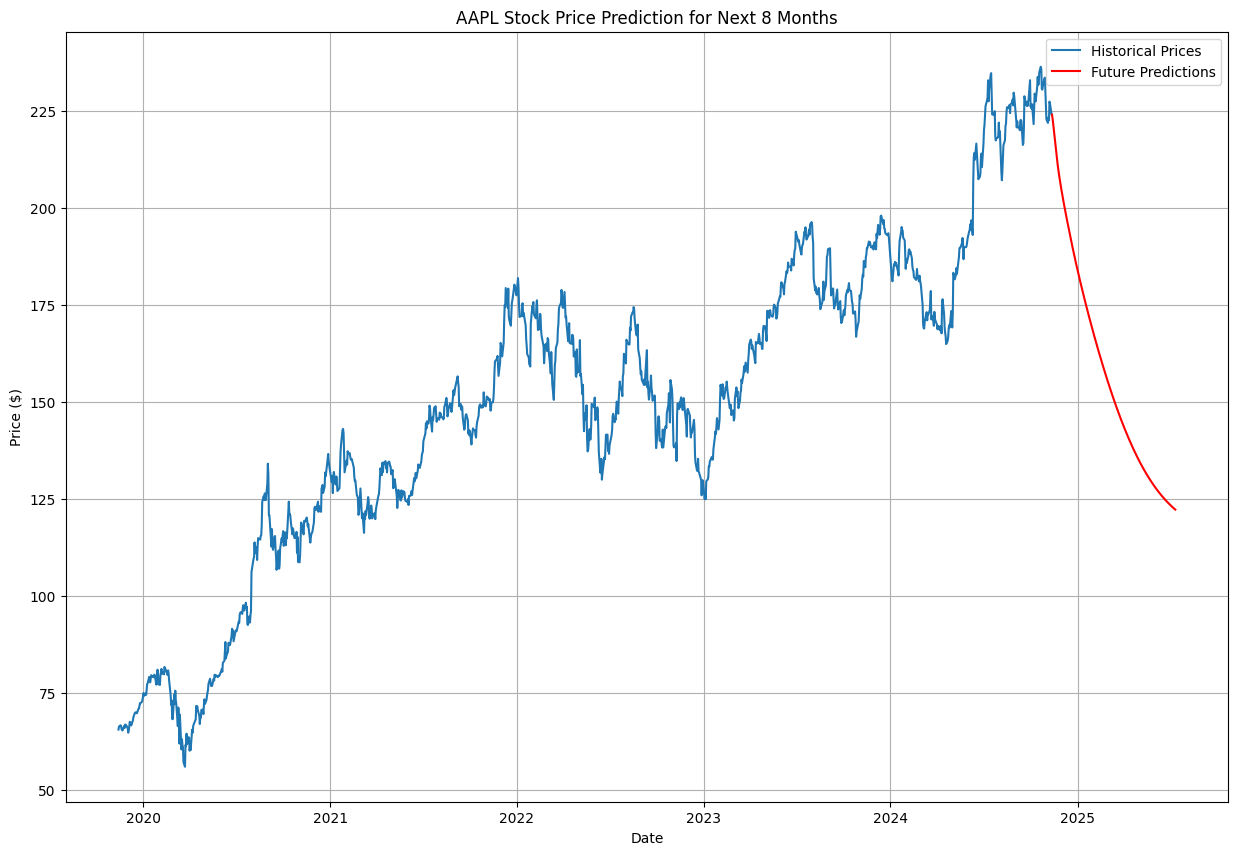


Predicted prices for AAPL:
1 month from now (2024-12-12): $196.49
3 months from now (2025-02-10): $163.62
6 months from now (2025-07-11): $122.34


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta

def get_stock_data(ticker, start_date, end_date):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            print(f"No data available for {ticker}. Please check the ticker symbol and try again.")
            return None
        return stock_data['Close']
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return None

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_lstm_model(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

def predict_future(model, last_sequence, num_days):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(num_days):
        prediction = model.predict(current_sequence.reshape(1, -1, 1))[0][0]
        future_predictions.append(prediction)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = prediction

    return np.array(future_predictions)

def main():
    ticker = input("Enter the stock ticker (e.g., AAPL): ").upper()
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
    seq_length = 60
    future_days = 242

    print(f"Fetching data for {ticker} from {start_date} to {end_date}")

    stock_data = get_stock_data(ticker, start_date, end_date)
    if stock_data is None:
        return

    print(f"Data fetched successfully. Last closing price: ${stock_data.iloc[-1].item():.2f}")

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data.values.reshape(-1, 1))

    X, y = create_sequences(scaled_data, seq_length)

    print("Training the LSTM model...")
    lstm_model = build_lstm_model(X, y)

    last_sequence = scaled_data[-seq_length:]

    print("Making predictions for the next 6 months...")
    future_scaled_predictions = predict_future(lstm_model, last_sequence, future_days)
    future_predictions = scaler.inverse_transform(future_scaled_predictions.reshape(-1, 1))

    last_date = stock_data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days)

    plt.figure(figsize=(15, 10))
    plt.plot(stock_data.index, stock_data.values, label='Historical Prices')
    plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')
    plt.title(f'{ticker} Stock Price Prediction for Next 8 Months')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    one_month_price = future_predictions[30][0]
    three_month_price = future_predictions[90][0]
    six_month_price = future_predictions[-1][0]

    print(f"\nPredicted prices for {ticker}:")
    print(f"1 month from now ({future_dates[30].strftime('%Y-%m-%d')}): ${one_month_price:.2f}")
    print(f"3 months from now ({future_dates[90].strftime('%Y-%m-%d')}): ${three_month_price:.2f}")
    print(f"6 months from now ({future_dates[-1].strftime('%Y-%m-%d')}): ${six_month_price:.2f}")

if __name__ == "__main__":
    main()